### 1. Environment Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import holidays 
from sklearn.model_selection import train_test_split
import os
#RANDOM_STATE = 42
#!pip install holidays


In [2]:
adir=1
if(adir==1):
    raw_data = pd.read_csv(r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data\data.csv")
else:
    raw_data = pd.read_csv(r"C:\Users\97252\Desktop\Chen_proj\data\data.csv")

raw_data.head(3)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,231974218,08/09/2021,01:06:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1006343,234270,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,177934247,04/07/2018,19:48:00,BROOKLYN,NaN,79,0.0,NaN,NaN,True,...,M,WHITE HISPANIC,25-44,M,BLACK,1000082.937500000000000,189064.671875000000000,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,255028563,12/02/2022,22:57:00,BRONX,OUTSIDE,47,0.0,STREET,GROCERY/BODEGA,False,...,(null),(null),25-44,M,BLACK,1020691,257125,40.872349,-73.868233,POINT (-73.868233 40.872349)


### 2. Initial Data Assessment & Type Handling

In [3]:
raw_data.shape

(29744, 21)

##### 2.1 Data Types

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29744 entries, 0 to 29743
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   INCIDENT_KEY             29744 non-null  int64  
 1   OCCUR_DATE               29744 non-null  object 
 2   OCCUR_TIME               29744 non-null  object 
 3   BORO                     29744 non-null  object 
 4   LOC_OF_OCCUR_DESC        4148 non-null   object 
 5   PRECINCT                 29744 non-null  int64  
 6   JURISDICTION_CODE        29742 non-null  float64
 7   LOC_CLASSFCTN_DESC       4148 non-null   object 
 8   LOCATION_DESC            14767 non-null  object 
 9   STATISTICAL_MURDER_FLAG  29744 non-null  bool   
 10  PERP_AGE_GROUP           20400 non-null  object 
 11  PERP_SEX                 20434 non-null  object 
 12  PERP_RACE                20434 non-null  object 
 13  VIC_AGE_GROUP            29744 non-null  object 
 14  VIC_SEX               

In [5]:
# Convert date and time columns
raw_data['OCCUR_DATE'] = pd.to_datetime(raw_data['OCCUR_DATE'], format='%m/%d/%Y')
raw_data['OCCUR_TIME'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S').dt.time

# Convert integer and boolean types
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('Int64')
raw_data['STATISTICAL_MURDER_FLAG'] = raw_data['STATISTICAL_MURDER_FLAG'].astype(bool)

# Convert categorical columns
categorical_cols = ['BORO', 'PERP_SEX','PERP_RACE', 'PERP_AGE_GROUP',
'VIC_SEX', 'VIC_RACE', 'VIC_AGE_GROUP','LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC','PRECINCT']

for col in categorical_cols:
    raw_data[col] = raw_data[col].astype('category')

# Remove commas from coordinates (handle as string first)
raw_data['X_COORD_CD'] = raw_data['X_COORD_CD'].astype(str).str.replace(',', '')
raw_data['Y_COORD_CD'] = raw_data['Y_COORD_CD'].astype(str).str.replace(',', '')

# Convert to float
raw_data['X_COORD_CD'] = pd.to_numeric(raw_data['X_COORD_CD'], errors='coerce')
raw_data['Y_COORD_CD'] = pd.to_numeric(raw_data['Y_COORD_CD'], errors='coerce')

In [6]:
raw_data.dtypes

INCIDENT_KEY                        int64
OCCUR_DATE                 datetime64[ns]
OCCUR_TIME                         object
BORO                             category
LOC_OF_OCCUR_DESC                category
PRECINCT                         category
JURISDICTION_CODE                   Int64
LOC_CLASSFCTN_DESC               category
LOCATION_DESC                    category
STATISTICAL_MURDER_FLAG              bool
PERP_AGE_GROUP                   category
PERP_SEX                         category
PERP_RACE                        category
VIC_AGE_GROUP                    category
VIC_SEX                          category
VIC_RACE                         category
X_COORD_CD                        float64
Y_COORD_CD                        float64
Latitude                          float64
Longitude                         float64
Lon_Lat                            object
dtype: object

In [7]:
# Check the type of the first element in the column
print(type(raw_data['OCCUR_TIME'].iloc[0]))

<class 'datetime.time'>


##### 2.2 Duplicate Rows

In [8]:
raw_data.duplicated().sum()

np.int64(0)

### 3. Technical Cleanup (Column Level)

In [9]:
raw_data.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'Lon_Lat'],
      dtype='object')

##### 3.1 Define Target Variable

In [10]:
source_col = 'STATISTICAL_MURDER_FLAG'
target_col = 'is_murder'

# Check if the source column exists to prevent errors on re-runs
if source_col in raw_data.columns:
    # 1. Convert Boolean (True/False) to Integer (1/0)
    raw_data[target_col] = raw_data[source_col].astype(int)

    # 2. Drop the original column 
    raw_data.drop(columns=[source_col], inplace=True)
    print(f"Dropped original column '{source_col}'.")

else:
    print(f"Column '{source_col}' not found (likely already dropped).")

# Verify the distribution of the new target variable
print(f"Target Distribution:")
print(raw_data[target_col].value_counts())


Dropped original column 'STATISTICAL_MURDER_FLAG'.
Target Distribution:
is_murder
0    23979
1     5765
Name: count, dtype: int64


##### **Class Imbalance detected.**<br>**Future Action:** Use Stratified K-Fold & Class Weights.

##### 3.2 Drop Irrelevant Columns

In [11]:
# Drop INCIDENT_KEY (Unique Identifier)
if 'INCIDENT_KEY' in raw_data.columns:
    raw_data.drop(columns=['INCIDENT_KEY'], inplace=True)
else:
    print("INCIDENT_KEY' not found (already dropped).")

In [12]:
# Define columns to check
cols = ['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat']
print("Counting Missing Values:")
print(raw_data[cols].isnull().sum())

Counting Missing Values:
X_COORD_CD     0
Y_COORD_CD     0
Latitude      97
Longitude     97
Lon_Lat       97
dtype: int64


Correlation Matrix
            X_COORD_CD  Y_COORD_CD  Latitude  Longitude
X_COORD_CD    1.000000    0.138655  0.137934   0.999998
Y_COORD_CD    0.138655    1.000000  1.000000   0.140439
Latitude      0.137934    1.000000  1.000000   0.139860
Longitude     0.999998    0.140439  0.139860   1.000000


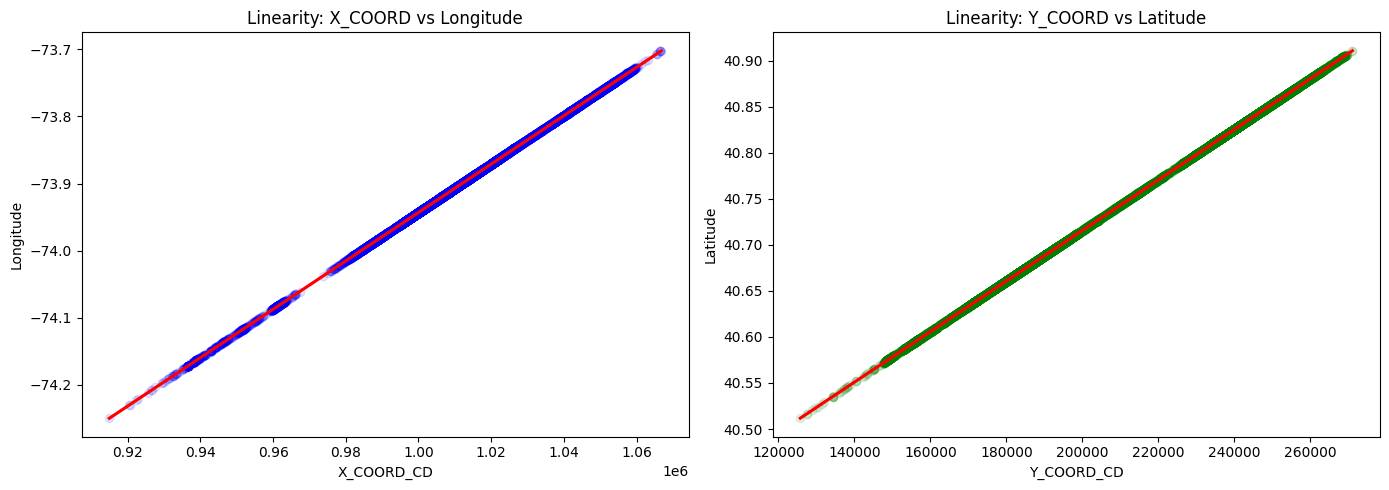

In [13]:
# 1. Necessary cleaning (removing commas and converting to numbers to prevent errors)
for col in ['X_COORD_CD', 'Y_COORD_CD']:
    if raw_data[col].dtype == 'object':
        raw_data[col] = raw_data[col].astype(str).str.replace(',', '').astype(float)

# 2. Print correlation matrix (text, not image)
cols = ['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']
print("Correlation Matrix")
print(raw_data[cols].corr())

# 3. Graphs to prove linearity (X and Y)
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot X vs Longitude
sns.regplot(ax=ax[0], x=raw_data['X_COORD_CD'], y=raw_data['Longitude'],
            scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
ax[0].set_title('Linearity: X_COORD vs Longitude')

# Plot Y vs Latitude
sns.regplot(ax=ax[1], x=raw_data['Y_COORD_CD'], y=raw_data['Latitude'],
            scatter_kws={'alpha': 0.1, 'color': 'green'}, line_kws={'color': 'red'})
ax[1].set_title('Linearity: Y_COORD vs Latitude')

plt.tight_layout()
plt.show()

In [14]:
raw_data[['Latitude', 'Longitude', 'Lon_Lat']].dropna().head()

,Latitude,Longitude,Lon_Lat
0,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,40.872349,-73.868233,POINT (-73.868233 40.872349)
3,40.642490,-73.996912,POINT (-73.99691224999998 40.642489932000046)
4,40.845984,-73.907461,POINT (-73.90746098599993 40.84598358900007)


#### Analysis & Validation

1.  **Perfect Linearity:** The correlation matrix and regression plots confirm a perfect linear relationship (Correlation $\approx$ 1.0) between the local NY projection (`X`/`Y`) and global coordinates (`Lat`/`Lon`). They represent identical spatial information.
2.  **Redundancy:** Visual inspection confirms that `Lon_Lat` is redundant, as it is merely a geometry POINT object constructed directly from the `Longitude` and `Latitude` values.

#### Strategic Decision

* **The Issue:** `Latitude` and `Longitude` contain 97 missing values (NaNs).
* **The Solution:** Since `X_COORD_CD` and `Y_COORD_CD` are 100% complete, we will use them as our primary spatial features.
* **Action:** Drop `Latitude`, `Longitude`, and `Lon_Lat`.
* **Impact:** Recovered 97 incident records that would otherwise be lost or require imputation.

In [15]:
raw_data.drop(columns=['Latitude', 'Longitude', 'Lon_Lat'], inplace=True)

### 4. Domain-Specific Sanity Checks & Logic

#####  Logic Validation - Category

In [16]:
def inspect_columns(df, cols_list, title="Columns", threshold=15, show_all=False):
    """
    Scans columns, prints values for small categories, and reports on large ones.
    
    Parameters:
    - df: raw_data
    - cols_list: List of column names to inspect
    - title: Title for the print block
    - threshold: Max unique values to print details for (default 15)
    - show_all: If True, ignores threshold and prints everything (for deep dives)
    
    Returns:
    - List of 'large' columns that exceeded the threshold
    """
    large_cols = []
    
    print(f"Inspecting: {title}")
    
    for col in cols_list:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame.")
            continue
            
        unique_vals = df[col].unique()
        n_unique = len(unique_vals)
        
        # Logic: Print if small enough OR if we forced 'show_all'
        if n_unique <= threshold or show_all:
            print(f"Column: {col} ({n_unique} values)")
            
            # Sort and print safely
            try:
                sorted_vals = sorted(unique_vals.tolist(), key=lambda x: str(x))
                print(f"Values: {sorted_vals}")
            except:
                print(f"Values: {unique_vals.tolist()}")
            
            # Check for missing values
            nans = df[col].isnull().sum()
            if nans > 0:
                print(f"Contains {nans} NaNs")
            
            print("-" * 40)
        
        else:
            # Save for summary
            large_cols.append(col)

    # Summary for large columns (only if we didn't show everything)
    if large_cols and not show_all:
        print(f"\n" + "="*40)
        print(f"{len(large_cols)} Large Columns (>{threshold} values)")
        for col in large_cols:
            n_val = df[col].nunique()
            print(f"{col} ({n_val} values)")
        print("="*40)
    elif not large_cols and not show_all:
        print(f"All columns in this group were small (<= {threshold}).")
        
    return large_cols

In [17]:
def plot_structural_missingness(df, cols, garbage_vals, title, custom_labels=None):
    """
    A function that analyzes Structural Missingness and displays a pie chart.
    
    Parameters:
    df: raw_data
    cols: List of columns to check
    garbage_vals: List of values considered "missing" (NaN, null, Unknown, etc.)
    title: Graph title
    custom_labels: List of 3 labels (Complete, All Missing, Partial). If not provided - uses default.
    """
    
    print(f"Analyzing: {title}")
    
    # 1. Calculate missing values
    # Check: Is the value in the garbage list or NaN
    missing_mask = df[cols].isin(garbage_vals) | df[cols].isnull()
    row_missing_sum = missing_mask.sum(axis=1)
    n_cols = len(cols)
    
    # 2. Define labels
    if custom_labels is None:
        labels = ['Complete Info', 'All Missing', 'Partial Info']
    else:
        labels = custom_labels

    # 3. Classify into categories
    conditions = [
        (row_missing_sum == 0),          # All complete
        (row_missing_sum == n_cols),     # All missing
        (row_missing_sum > 0) & (row_missing_sum < n_cols) # Partial
    ]
    
    # Create a temporary series (without modifying the original df)
    quality_series = np.select(conditions, labels, default='Other')
    
    # 4. Prepare data for the plot
    counts = pd.Series(quality_series).value_counts()
    # Sort by logical order (Complete -> Missing -> Partial) and handle cases with no Partial
    ordered_counts = counts.reindex(labels).fillna(0)
    
    # Print numerical data
    print(ordered_counts)

    # 5. Create pie chart
    plt.figure(figsize=(5, 5))
    colors = sns.color_palette('pastel')[0:3]
    explode = (0.05, 0.05, 0.1) 
    
    plt.pie(ordered_counts, 
            labels=ordered_counts.index,
            autopct='%1.1f%%',
            startangle=140,
            colors=colors,
            explode=explode,
            shadow=True,
            textprops={'fontsize': 10, 'weight': 'bold'})
    
    plt.title(title, fontsize=12)
    plt.show()

In [18]:
perp_cols = ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
inspect_columns(raw_data, perp_cols, title="Suspect Data")

Inspecting: Suspect Data
Column: PERP_AGE_GROUP (13 values)
Values: ['(null)', '1020', '1028', '18-24', '2021', '224', '25-44', '45-64', '65+', '940', '<18', 'UNKNOWN', nan]
Contains 9344 NaNs
----------------------------------------
Column: PERP_SEX (5 values)
Values: ['(null)', 'F', 'M', 'U', nan]
Contains 9310 NaNs
----------------------------------------
Column: PERP_RACE (9 values)
Values: ['(null)', 'AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC', nan]
Contains 9310 NaNs
----------------------------------------
All columns in this group were small (<= 15).


[]

#### Hypothesis Verification: Structural Missingness in Suspect Data

**Hypothesis:** Missing values in Suspect columns (`PERP_SEX`, `PERP_RACE`, `PERP_AGE_GROUP`) are not random data entry errors. Instead, they represent a specific real-world event: The suspect was not identified or caught.

**Method:**
We will check for correlation between missing or "garbage" values across these three columns. If a row has missing info in one column, we expect it to be missing in all three.

Analyzing: Suspect Data Completeness
Complete Info (Caught)    15460
All Missing (Unknown)     12404
Partial Info               1880
Name: count, dtype: int64


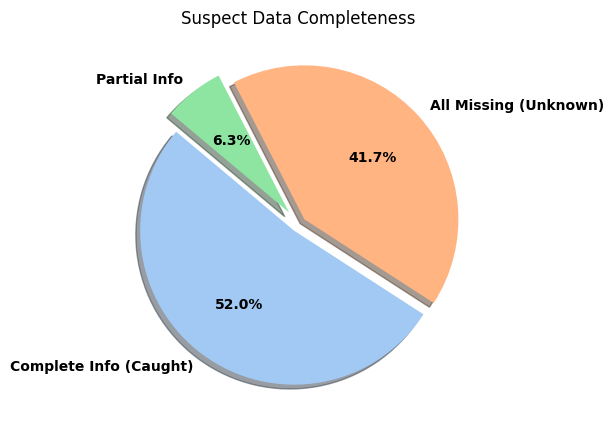

In [19]:
# Definitions for suspects
perp_cols = ['PERP_SEX', 'PERP_RACE', 'PERP_AGE_GROUP']
perp_garbage = [np.nan, '(null)', 'UNKNOWN', 'U', '1020', '940', '224', '2021', '1022']
perp_labels = ['Complete Info (Caught)', 'All Missing (Unknown)', 'Partial Info']

# Function call
plot_structural_missingness(
    raw_data, 
    perp_cols, 
    perp_garbage, 
    title='Suspect Data Completeness', 
    custom_labels=perp_labels
)

####  Analysis: Structural Missingness Verification

**Observation:**
The pie chart confirms an "All or Nothing" pattern. 41.7% of incidents miss all suspect features (Sex, Race, Age) simultaneously, while only 6.3% have partial information.

**Conclusion & Action:**
* **Validation:** The synchronized missingness confirms these are unsolved cases (suspect not apprehended), not random data errors.
* **Strategy:** We will not drop these rows, as removing ~48% of the data would introduce severe survivorship bias (training only on solved crimes).
* **Imputation:** All missing values will be mapped to a standardized 'Unknown' category to preserve the "unsolved" signal for the model.

In [20]:
# Define Suspect columns and values to replace
perp_cols = ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE']
garbage = ['(null)', 'UNKNOWN', 'U', '1020', '1028', '940', '224', '2021', np.nan]

# Perform cleaning in a quick operation chain:
# Convert to object -> Replace garbage -> Fill missing -> Convert to category
raw_data[perp_cols] = raw_data[perp_cols].astype('object').replace(garbage, 'Unknown').fillna('Unknown').astype('category')

print("Suspect columns cleaned to 'Unknown'.")

Suspect columns cleaned to 'Unknown'.


In [21]:
vic_cols = ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']
inspect_columns(raw_data, vic_cols, title="Victim Data")

Inspecting: Victim Data
Column: VIC_AGE_GROUP (7 values)
Values: ['1022', '18-24', '25-44', '45-64', '65+', '<18', 'UNKNOWN']
----------------------------------------
Column: VIC_SEX (3 values)
Values: ['F', 'M', 'U']
----------------------------------------
Column: VIC_RACE (7 values)
Values: ['AMERICAN INDIAN/ALASKAN NATIVE', 'ASIAN / PACIFIC ISLANDER', 'BLACK', 'BLACK HISPANIC', 'UNKNOWN', 'WHITE', 'WHITE HISPANIC']
----------------------------------------
All columns in this group were small (<= 15).


[]

In [22]:
# 1. Define victim columns
vic_cols = ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE']

# 2. Specific garbage list for victims (based on your output)
# U = Abbreviation for Unknown
# 1022 = Unrealistic age
vic_garbage = ['U', '1022', 'UNKNOWN', '(null)'] 

print("Standardizing Victim Data")

# 3. Efficient one-line cleaning
# Convert to object -> Replace garbage -> Fill missing (safety) -> Convert back to category
raw_data[vic_cols] = raw_data[vic_cols].astype('object').replace(vic_garbage, 'Unknown').fillna('Unknown').astype('category')

print("Victim columns cleaned (U/1022 -> Unknown).")

Standardizing Victim Data
Victim columns cleaned (U/1022 -> Unknown).


**Observation:**
In contrast to the suspect data, the Victim data is highly complete (since victims are usually identified at the scene). We observed no structural missingness, only minor data entry inconsistencies:
* `'U'` (Legacy code for Unknown).
* `'1022'` (Impossible age value).

**Action:**
We are performing a simple technical cleanup to map these specific artifacts to the standardized 'Unknown' category.

In [23]:
loc_cols = ['BORO', 'LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC', 'PRECINCT']
large_locations = inspect_columns(raw_data, loc_cols, title="Location Data")

Inspecting: Location Data
Column: BORO (5 values)
Values: ['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']
----------------------------------------
Column: LOC_OF_OCCUR_DESC (3 values)
Values: ['INSIDE', 'OUTSIDE', nan]
Contains 25596 NaNs
----------------------------------------
Column: LOC_CLASSFCTN_DESC (11 values)
Values: ['(null)', 'COMMERCIAL', 'DWELLING', 'HOUSING', 'OTHER', 'PARKING LOT', 'PLAYGROUND', 'STREET', 'TRANSIT', 'VEHICLE', nan]
Contains 25596 NaNs
----------------------------------------

2 Large Columns (>15 values)
LOCATION_DESC (40 values)
PRECINCT (77 values)


Analyzing: Location Data Completeness
Complete Loc Info         4141
No Loc Info (Unknown)    25596
Partial Loc Info             7
Name: count, dtype: int64


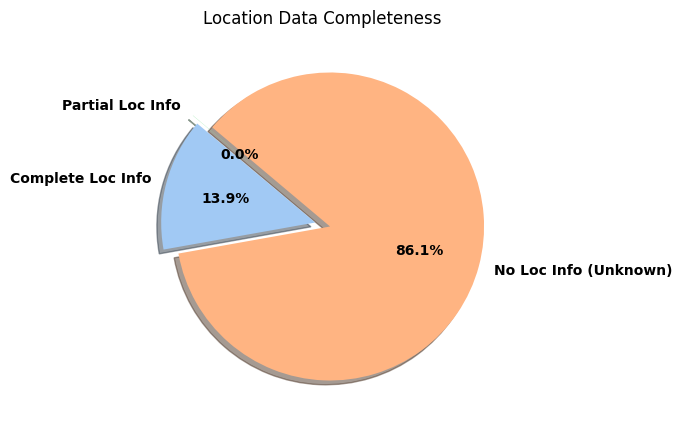

In [24]:
# Definitions for location
loc_cols = ['LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC']
loc_garbage = [np.nan, '(null)']
loc_labels = ['Complete Loc Info', 'No Loc Info (Unknown)', 'Partial Loc Info']

# Function call
plot_structural_missingness(
    raw_data, 
    loc_cols, 
    loc_garbage, 
    title='Location Data Completeness', 
    custom_labels=loc_labels
)

**Observation:**
* **High Missingness:** ~86.1% of records lack specific location descriptions.
* **Structural Proof:** Our analysis reveals 0.0% partial missingness. This confirms a structural pattern: incidents are either fully documented (13.9%) or completely undocumented.

**Strategy:**
We will retain these columns. Dropping them would discard high-quality signals from the ~3,500 fully documented cases. Instead, we map the structural gap to a new explicit category: 'Unknown'.

In [25]:
loc_cols = ['LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC']
loc_garbage = ['(null)', np.nan]

raw_data[loc_cols] = raw_data[loc_cols].astype('object').replace(loc_garbage, 'Unknown').fillna('Unknown').astype('category')

print(f"Location columns cleaned. Missing values mapped to 'Unknown'.")

Location columns cleaned. Missing values mapped to 'Unknown'.


In [26]:
pd.set_option('display.max_colwidth', None)
inspect_columns(raw_data, large_locations, title="Deep Dive: Large Location Columns", show_all=True)

Inspecting: Deep Dive: Large Location Columns
Column: LOCATION_DESC (41 values)
Values: ['(null)', 'ATM', 'BANK', 'BAR/NIGHT CLUB', 'BEAUTY/NAIL SALON', 'CANDY STORE', 'CHAIN STORE', 'CHECK CASH', 'CLOTHING BOUTIQUE', 'COMMERCIAL BLDG', 'DEPT STORE', 'DOCTOR/DENTIST', 'DRUG STORE', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'FAST FOOD', 'GAS STATION', 'GROCERY/BODEGA', 'GYM/FITNESS FACILITY', 'HOSPITAL', 'HOTEL/MOTEL', 'JEWELRY STORE', 'LIQUOR STORE', 'LOAN COMPANY', 'MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'NONE', 'PHOTO/COPY STORE', 'PVT HOUSE', 'RESTAURANT/DINER', 'SCHOOL', 'SHOE STORE', 'SMALL MERCHANT', 'SOCIAL CLUB/POLICY LOCATI', 'STORAGE FACILITY', 'STORE UNCLASSIFIED', 'SUPERMARKET', 'TELECOMM. STORE', 'VARIETY STORE', 'VIDEO STORE', nan]
Contains 14977 NaNs
----------------------------------------
Column: PRECINCT (77 values)
Values: [1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 120, 121, 122, 123, 13, 14, 17, 18, 19, 

[]


**Observation:**
* **`PRECINCT`:** Validated. Contains 77 unique police precinct codes with no missing values or zeros.
* **`LOCATION_DESC`:** Contains valuable specific details (e.g., 'BAR/NIGHT CLUB'), but ~50% of the data is missing or labeled as 'NONE'/'(null)'.

**Action:**
* **`PRECINCT`:** Keep as is (ensure categorical type).
* **`LOCATION_DESC`:** Standardize `NaN`, `(null)`, and `NONE` to 'Unknown' to retain the 50% of high-quality location labels.

In [27]:
# 1. Handling LOCATION_DESC
# Added 'NONE' to the garbage list (in addition to null and NaN)
loc_desc_garbage = ['(null)', 'NONE', np.nan]

print("Standardizing Specific Location Description:")

# Convert -> Replace -> Fill -> Category
raw_data['LOCATION_DESC'] = raw_data['LOCATION_DESC'].astype('object').replace(loc_desc_garbage, 'Unknown').fillna('Unknown').astype('category')
print(f" LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.")

# 2. Verify that PRECINCT is a category (and not a number)
# This is important because precinct 100 is not "2x" precinct 50, it is just a station name
raw_data['PRECINCT'] = raw_data['PRECINCT'].astype('category')
print(f" PRECINCT validated and set to Category type.")


Standardizing Specific Location Description:
 LOCATION_DESC cleaned. Mapped 'NONE'/'(null)' to 'Unknown'.
 PRECINCT validated and set to Category type.


##### Feature Engineering: Semantic Grouping

In [28]:
# List of columns we want to check before grouping
cols_to_check = ['PERP_RACE', 'VIC_RACE','LOC_CLASSFCTN_DESC','LOCATION_DESC']

print("Frequency Check for Grouping Strategy")

for col in cols_to_check:
    if col in raw_data.columns:
        print(f"Column: {col}")
        
        # Count occurrences
        counts = raw_data[col].value_counts()
        
        # Calculate percentages
        percentages = raw_data[col].value_counts(normalize=True) * 100
        
        # Combine into a clear table
        summary = pd.concat([counts, percentages], axis=1, keys=['Count', 'Percent'])
        
        # Display the table (if too long, show the top 15 and the tail)
        if len(summary) > 20:
             print(summary.head(15))
             print("\n... (Tail of list) ...")
             print(summary.tail(5))
        else:
            print(summary)
            
        print("-" * 50)

Frequency Check for Grouping Strategy
Column: PERP_RACE
                                Count    Percent
PERP_RACE                                       
Unknown                         12776  42.953201
BLACK                           12323  41.430204
WHITE HISPANIC                   2667   8.966514
BLACK HISPANIC                   1487   4.999328
WHITE                             305   1.025417
ASIAN / PACIFIC ISLANDER          184   0.618612
AMERICAN INDIAN/ALASKAN NATIVE      2   0.006724
--------------------------------------------------
Column: VIC_RACE
                                Count    Percent
VIC_RACE                                        
BLACK                           20999  70.599112
WHITE HISPANIC                   4511  15.166084
BLACK HISPANIC                   2930   9.850726
WHITE                             741   2.491259
ASIAN / PACIFIC ISLANDER          478   1.607047
Unknown                            72   0.242066
AMERICAN INDIAN/ALASKAN NATIVE     13   0.0

In [29]:
# 1. Exact Mapping (39 values)
groups = {
    'Residential': ['MULTI DWELL - APT BUILD', 'MULTI DWELL - PUBLIC HOUS', 'PVT HOUSE', 'HOTEL/MOTEL'],
    
    'Food_Nightlife': ['BAR/NIGHT CLUB', 'LIQUOR STORE', 'SOCIAL CLUB/POLICY LOCATI', 'GROCERY/BODEGA', 
                       'RESTAURANT/DINER', 'FAST FOOD', 'SUPERMARKET'],
    
    'Public_Place': ['SCHOOL', 'HOSPITAL', 'BANK', 'ATM', 'DOCTOR/DENTIST', 'GYM/FITNESS FACILITY', 'GAS STATION'],
    
    'Commercial': ['STORE UNCLASSIFIED', 'CHAIN STORE', 'DEPT STORE', 'VARIETY STORE', 'SMALL MERCHANT',
                   'CLOTHING BOUTIQUE', 'SHOE STORE', 'JEWELRY STORE', 'BEAUTY/NAIL SALON', 'DRUG STORE',
                   'CANDY STORE', 'TELECOMM. STORE', 'VIDEO STORE', 'PHOTO/COPY STORE', 'CHECK CASH',
                   'LOAN COMPANY', 'DRY CLEANER/LAUNDRY', 'FACTORY/WAREHOUSE', 'COMMERCIAL BLDG', 'STORAGE FACILITY'],
    
    'Unknown': ['Unknown', '(null)', np.nan]
}

flat_map = {val: key for key, lst in groups.items() for val in lst}

print("Feature Engineering: Exact Grouping")

# 2. Apply location mapping
raw_data['LOCATION_GROUP'] = raw_data['LOCATION_DESC'].map(flat_map).fillna('Unknown').astype('category')

# 3. Apply race mapping
raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(
    'AMERICAN INDIAN/ALASKAN NATIVE', 'Other').astype('category')

# Check Location
print("\nLocation Group Counts:")
print(raw_data['LOCATION_GROUP'].value_counts())

# Check Race (To verify 'Other' replacement)
print("\nPerpetrator Race Counts:")
print(raw_data['PERP_RACE'].value_counts())

print("\nVictim Race Counts:")
print(raw_data['VIC_RACE'].value_counts())

Feature Engineering: Exact Grouping

Location Group Counts:
LOCATION_GROUP
Unknown           17678
Residential        9278
Food_Nightlife     1954
Commercial          664
Public_Place        170
Name: count, dtype: int64

Perpetrator Race Counts:
PERP_RACE
Unknown                     12776
BLACK                       12323
WHITE HISPANIC               2667
BLACK HISPANIC               1487
WHITE                         305
ASIAN / PACIFIC ISLANDER      184
Other                           2
Name: count, dtype: int64

Victim Race Counts:
VIC_RACE
BLACK                       20999
WHITE HISPANIC               4511
BLACK HISPANIC               2930
WHITE                         741
ASIAN / PACIFIC ISLANDER      478
Unknown                        72
Other                          13
Name: count, dtype: int64


C:\Users\Adir\AppData\Local\Temp\ipykernel_26792\697798416.py:26: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  raw_data[['PERP_RACE', 'VIC_RACE']] = raw_data[['PERP_RACE', 'VIC_RACE']].replace(


**Strategy:**
To reduce noise and prevent overfitting (due to high cardinality), we mapped the 39 raw values of `LOCATION_DESC` into 5 robust semantic groups based on environmental risk profiles:
* **Groups:** `Residential`, `Commercial`, `Food_Nightlife`, `Public_Place`, `Unknown`.

**Cleanup:**
Simultaneously, we merged negligible race categories (<0.1%) into 'Other' to ensure all features have sufficient statistical weight for the models.

#####  Logic Validation - other types

In [30]:
# Cell: Sanity Check - Temporal Data Validity

print("Checking OCCUR_DATE Validity")
# 1. Check Date Range
min_date = raw_data['OCCUR_DATE'].min()
max_date = raw_data['OCCUR_DATE'].max()

print(f"Earliest Date in dataset: {min_date}")
print(f"Latest Date in dataset:   {max_date}")

# Logic Validation: Ensure no future dates
if max_date > pd.Timestamp.now():
    print("WARNING: Future dates detected! Check your data source.")
else:
    print("Date range is logical.")

print("\nChecking OCCUR_TIME Validity")
# 2. Check Time Logic
# Assuming OCCUR_TIME is string/object (e.g., '14:30:00')
# We check the lexicographical min/max to ensure they are within '00:00:00' and '23:59:59'
min_time = raw_data['OCCUR_TIME'].min()
max_time = raw_data['OCCUR_TIME'].max()

print(f"Earliest Time recorded: {min_time}")
print(f"Latest Time recorded:   {max_time}")

# Quick check for invalid time strings (like '24:00' or empty)
# Converting to datetime temporarily to catch format errors
try:
    temp_times = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce')
    invalid_times = temp_times.isna().sum()
    if invalid_times == 0:
        print("All time values are in valid HH:MM:SS format.")
    else:
        print(f"WARNING: Found {invalid_times} invalid time values (NaN after conversion).")
except Exception as e:
    print(f"Error checking time format: {e}")

Checking OCCUR_DATE Validity
Earliest Date in dataset: 2006-01-01 00:00:00
Latest Date in dataset:   2024-12-31 00:00:00
Date range is logical.

Checking OCCUR_TIME Validity
Earliest Time recorded: 00:00:00
Latest Time recorded:   23:59:00
All time values are in valid HH:MM:SS format.



**Objective:**
To validate that logical/numerical columns contain expected values before proceeding to modeling.

**Checks:**
1.  **Jurisdiction Code:** Verify it contains only the 3 known legal jurisdictions (0=Patrol, 1=Transit, 2=Housing).
2.  **Target Variable (`is_murder`):** Confirm binary distribution (True/False).
3.  **Geo-Spatial Data:** Validate that Latitude/Longitude values fall within the valid range of New York City boundaries.

In [31]:
print("Categorical/Discrete Validity Check")

# 1. Jurisdiction Code Check (Should be 0, 1, 2)
# 0 = Patrol, 1 = Transit, 2 = Housing
print(raw_data['JURISDICTION_CODE'].value_counts(dropna=False).sort_index())

# 2. Target Column Check (Was it a murder)
print(raw_data['is_murder'].value_counts(dropna=False))

print("\n" + "="*40)
print("Geo-Spatial Range Check")

# 3. Coordinate Range Check (NY State Plane System)
# NYC Approximate Bounds (in Feet):
# X (Easting):  900,000 to 1,100,000
# Y (Northing): 100,000 to 300,000

geo_stats = raw_data[['Y_COORD_CD', 'X_COORD_CD']].describe().loc[['min', 'max', 'mean', 'std']]
print(geo_stats)

# Quick logical check using State Plane bounds
y_valid = (geo_stats.loc['min', 'Y_COORD_CD'] > 100000) and (geo_stats.loc['max', 'Y_COORD_CD'] < 300000)
x_valid = (geo_stats.loc['min', 'X_COORD_CD'] > 900000) and (geo_stats.loc['max', 'X_COORD_CD'] < 1100000)

if y_valid and x_valid:
    print("Coordinates are within valid NYC State Plane range.")
else:
    print("WARNING: Coordinates might be out of range!")

Categorical/Discrete Validity Check
JURISDICTION_CODE
0       24957
1         109
2        4676
<NA>        2
Name: count, dtype: Int64
is_murder
0    23979
1     5765
Name: count, dtype: int64

Geo-Spatial Range Check
         Y_COORD_CD    X_COORD_CD
min   125756.718750  9.149281e+05
max   271127.687500  1.066815e+06
mean  208721.993401  1.009442e+06
std    31931.604578  1.821818e+04
Coordinates are within valid NYC State Plane range.


In [32]:
# 1. Check for the most frequent value (usually 0)
mode_val = raw_data['JURISDICTION_CODE'].mode()[0]
print(f"Most frequent value: {mode_val}")

# 2. Fill NaNs with the mode and convert to int (to get rid of the decimal point)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].fillna(mode_val).astype(int)

# 3. Convert to category (as planned for discrete variables)
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('category')

print(f"Filled NaNs with {mode_val}")
print(raw_data['JURISDICTION_CODE'].value_counts())

Most frequent value: 0
Filled NaNs with 0
JURISDICTION_CODE
0    24959
2     4676
1      109
Name: count, dtype: int64


### 5. Pre-Split Feature Engineering (Row-Level)

In [33]:
# 1. Extract Date-Based Features
if 'OCCUR_DATE' in raw_data.columns:
    # Numeric month (1-12) for seasonality
    raw_data['Month'] = raw_data['OCCUR_DATE'].dt.month
    # Day name (Monday, Tuesday...) for categorical analysis
    raw_data['DayOfWeek'] = raw_data['OCCUR_DATE'].dt.day_name()

# 2. Extract Time-Based Features
if 'OCCUR_TIME' in raw_data.columns:
    # Extract Hour (0-23)
    raw_data['Hour'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S', errors='coerce').dt.hour

# 3. Create Aggregated Features

# A. Part of Day Buckets
def get_part_of_day(h):
    if pd.isna(h): return 'Unknown'
    h = int(h)
    if 5 <= h < 12: return 'Morning'
    elif 12 <= h < 17: return 'Afternoon'
    elif 17 <= h < 23: return 'Evening'
    else: return 'Night'

if 'Hour' in raw_data.columns:
    raw_data['Part_of_Day'] = raw_data['Hour'].apply(get_part_of_day)

# B. Weekend Flag
if 'DayOfWeek' in raw_data.columns:
    weekend_days = ['Friday', 'Saturday', 'Sunday']
    raw_data['is_weekend'] = raw_data['DayOfWeek'].isin(weekend_days).astype(int)

# C. Holiday Features
# Initialize US Holidays for NY
us_holidays = holidays.US(subdiv='NY')

def get_holiday_name(date_obj):
    return us_holidays.get(date_obj)

# Create holiday columns
raw_data['holiday_name'] = raw_data['OCCUR_DATE'].apply(get_holiday_name)
raw_data['holiday_name'] = raw_data['holiday_name'].fillna('Not Holiday')
raw_data['is_holiday'] = (raw_data['holiday_name'] != 'Not Holiday').astype(int)

# D. Season Features (NYC Meteorological Seasons)
if 'Month' in raw_data.columns:
    def get_season(month):
        if month in [12, 1, 2]: return 'Winter'
        elif month in [3, 4, 5]: return 'Spring'
        elif month in [6, 7, 8]: return 'Summer'
        else: return 'Fall'

    raw_data['Season'] = raw_data['Month'].apply(get_season)

print("Feature Engineering completed.")

# 4. Final Verification Table 

raw_data[['OCCUR_DATE', 'OCCUR_TIME', 'Month', 'DayOfWeek', 'Hour', 'Part_of_Day', 'is_weekend',
           'is_holiday', 'holiday_name', 'Season']].head(3)

Feature Engineering completed.


,OCCUR_DATE,OCCUR_TIME,Month,DayOfWeek,Hour,Part_of_Day,is_weekend,is_holiday,holiday_name,Season
0,2021-08-09,01:06:00,8,Monday,1,Night,0,0,Not Holiday,Summer
1,2018-04-07,19:48:00,4,Saturday,19,Evening,1,0,Not Holiday,Spring
2,2022-12-02,22:57:00,12,Friday,22,Evening,1,0,Not Holiday,Winter


### Train-Test Split

##### 6. Strategic Data Splitting

In [34]:
# 1. Define X (Features) and y (Target)
y = raw_data['is_murder']
X = raw_data.drop(columns=['is_murder'])

print(f"Performing Stratified Split (80/20)")

# 2. Perform Split
# stratify=y is crucial here due to the class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

# 3. Validation
print(f"Train Shape: {X_train.shape}")
print(f"Test Shape:  {X_test.shape}")

# Calculate Ratios
train_ratio = y_train.value_counts(normalize=True)[1]
test_ratio = y_test.value_counts(normalize=True)[1]

print(f"\nMurder Ratio in Train: {train_ratio:.4f}")
print(f"Murder Ratio in Test:  {test_ratio:.4f}")

# Confirmation
if abs(train_ratio - test_ratio) < 0.01:
    print("Stratification Successful: Ratios are consistent.")
else:
    print("WARNING: Ratios differ significantly!")

Performing Stratified Split (80/20)
Train Shape: (23795, 25)
Test Shape:  (5949, 25)

Murder Ratio in Train: 0.1938
Murder Ratio in Test:  0.1938
Stratification Successful: Ratios are consistent.


##### 7. Synthetic Missingness Injection

In [35]:
def inject_nans(df, cols, fraction=0.15, random_state=42):
    """
    Creates a COPY of the dataframe and injects NaNs into specific columns.
    Returns the modified copy.
    """
    df_copy = df.copy()
    np.random.seed(random_state)
    
    for col in cols:
        if col in df_copy.columns:
            # Create a boolean mask for random selection
            mask = np.random.rand(len(df_copy)) < fraction
            # Set selected values to NaN
            df_copy.loc[mask, col] = np.nan
            
            print(f"Injected {fraction*100}% NaNs into: {col}")
    
    return df_copy

# Columns to corrupt for the experiment (Coordinates)
cols_to_inject = ['X_COORD_CD', 'Y_COORD_CD']

# 1. Keep the Clean Version (Baseline) - We don't touch X_train/X_test
print("X_train and X_test kept clean for Baseline.")

# 2. Create the Missing Version (Experiment)
X_train_missing = inject_nans(X_train, cols_to_inject, fraction=0.15)
X_test_missing = inject_nans(X_test, cols_to_inject, fraction=0.15)

X_train and X_test kept clean for Baseline.
Injected 15.0% NaNs into: X_COORD_CD
Injected 15.0% NaNs into: Y_COORD_CD
Injected 15.0% NaNs into: X_COORD_CD
Injected 15.0% NaNs into: Y_COORD_CD


##### 8. Final Data Export

In [36]:
# Define the exact output directory
output_dir = r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data"

# Ensure directory exists - create if necessary
os.makedirs(output_dir, exist_ok=True)

# 1. Save Clean Data (For Baseline & Control)
X_train.to_csv(os.path.join(output_dir, 'X_train_clean.csv'), index=False)
X_test.to_csv(os.path.join(output_dir, 'X_test_clean.csv'), index=False)

# 2. Save Data with Missing Values (For Imputation Experiments)
X_train_missing.to_csv(os.path.join(output_dir, 'X_train_missing.csv'), index=False)
X_test_missing.to_csv(os.path.join(output_dir, 'X_test_missing.csv'), index=False)

# 3. Save Targets (Same for both sets)
y_train.to_csv(os.path.join(output_dir, 'y_train.csv'), index=False)
y_test.to_csv(os.path.join(output_dir, 'y_test.csv'), index=False)

print("All files exported successfully")

All files exported successfully
